### 2024.9.6 22:40
现在是写完了联合标签训练的测试，但有问题：第一个是标签不均衡的问题，共有的那几个类几率会增高，显然不对劲。
另一个是MLP的drop_out上，train和val的时候输出的logits差别很大。train的时候是正常的，但val时候所有样本logits同质化。原因好像是val的时候会自动关闭模型中的dropout层（删掉dropout会导致train和val全变成左边的样子......
现在是准备跑一下单个数据集（Faced 9 class）上的Baseline，看看logits同质化的问题是否只是初期现象，会不会随着训练好转。

#### val时batch内logits同质化，以及train时的正常logits，以及对应标签（Faced 56*9）
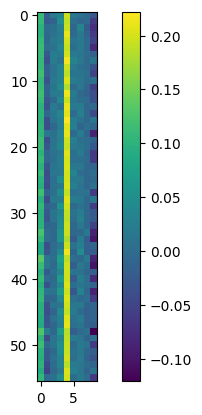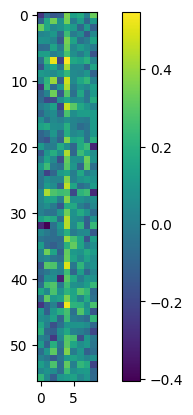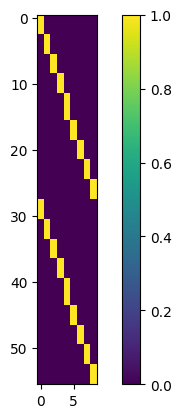
#### 计算的一个batch的de特征实例，看起来还算正常？
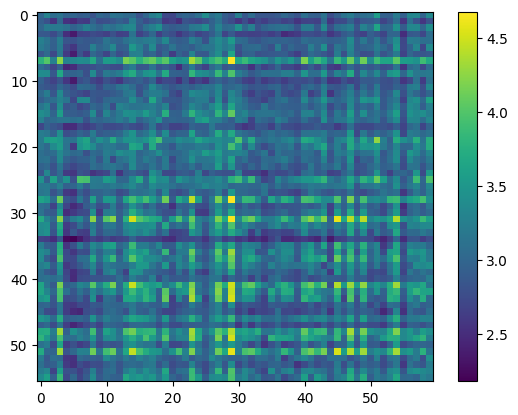
#### 标签不均衡logits
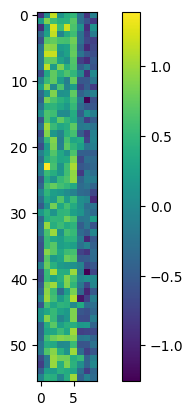

#### 涉事MLP代码

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, dropout=0.2, bn='no'):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # if (bn == 'bn1') or (bn == 'bn2'):
        self.bn1 = nn.BatchNorm1d(hidden_dim, affine=False)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        # if bn == 'bn2':
        self.bn2 = nn.BatchNorm1d(hidden_dim//2, affine=False)
        self.fc3 = nn.Linear(hidden_dim//2, out_dim)
        self.bn = bn
        self.drop = nn.Dropout(p=dropout)
        # self.flag = False
    def forward(self, input):

        out = F.relu(self.fc1(input))

        if (self.bn == 'bn1') or (self.bn == 'bn2'):
            out = self.bn1(out)
        out = self.drop(out)
        out = F.relu(self.fc2(out))

        if self.bn == 'bn2':
            out = self.bn2(out)
        out = self.drop(out)
        out = self.fc3(out)

        return out

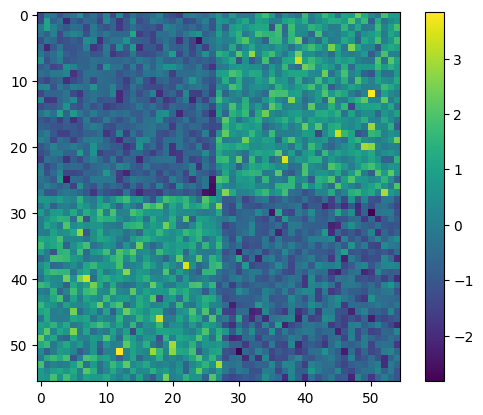

### 2024.9.11 13:36
现在能正常过拟合了，但是非常慢。要几个小时。

该版本代码：https://github.com/soul-M-42/Covariance_EEG_Emotion/commit/cabc8cad0eb390cf5e1ee75b9e1ea876b3e31a3c

该版本loss和acc：\\10.16.32.74\dataset0\qingzhu\workspace\log_worth\24_9_11_clisa_Proj_only

loss和acc预览（橙色为fold0,蓝色为fold1）：
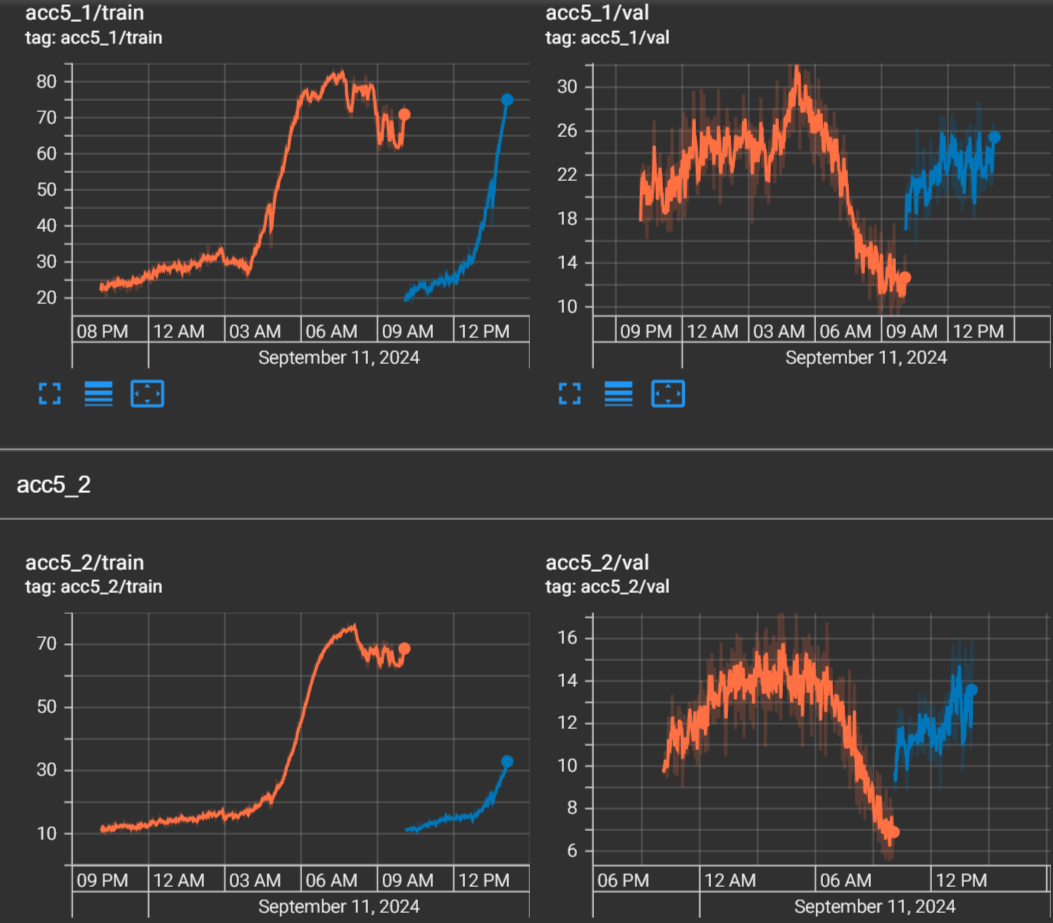
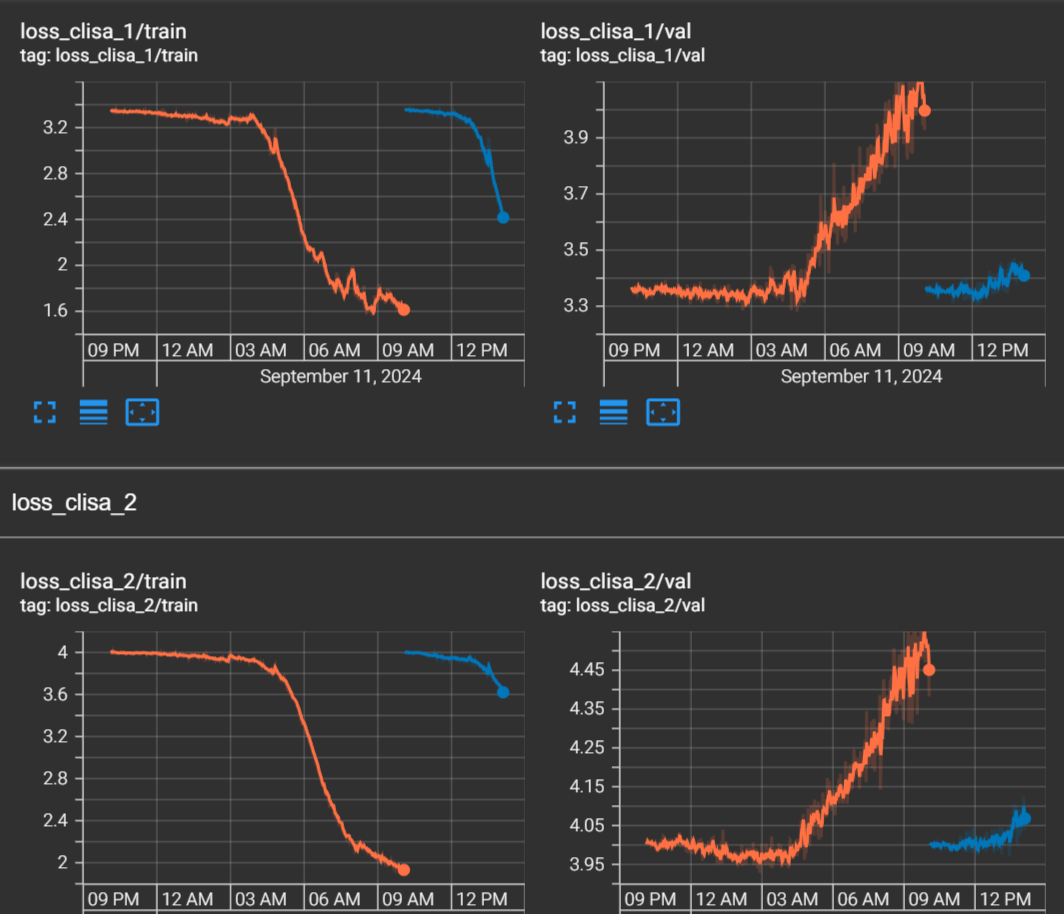

可能导致该变化的调整：
1. 在以下位置加入strafied_layernorm：[EEG数据输入，Clisa_Proj(和新科版本Clisa_Proj保持一致)]
2. 修改了stratified_layernorm的细节，改回了正确版本的老norm
3. 向loss_clisa_fea中加入了temperature=0.3项

为何过拟合得这么慢？有以下猜测：
1. 是在用两个数据集训练一套参数，数据本身就比较diverse
2. wd=0
3. lr start from 1e-2
4. 降低MLLA输出维度
5. 单个数据集验证
6. 加入对齐loss


### 2024.9.12
#### 修改sampler，在全部数据上，但限制样本对数量，随机！

重要更新1：之前收敛速度瓶颈在Channel_Alignment上。之前相当于把[batch_size, n_channel, n_dim]的数据先reshape成[batch_size, -1]再用一个[n_channel*n_dim]的参数量巨大的全连接进行对齐。现在改成了只在n_channel维度上进行线性组合。

重要更新2：clisa_proj的卷积，同样不merge两个维度，而是定义在一个方向上kernel_size为1，另一个方向上为正常size。

总之：避免数据某一维度贼大